# IMBD Sentiment Analysis PT-BR

[Here](https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr) you can find the IMDB PT-BR data set on Kaggle.

All the code was written in Python 3, using Jupyter Notebooks.

**For more info, check the README.**

In [1]:
# Importing libraries

import nltk 
from nltk import FreqDist, RSLPStemmer, tokenize
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from string import punctuation
from unidecode import unidecode

from utils.plotting import plot_confusion_matrix, plot_roc_auc, plot_word_cloud

---

# EDA 

Let's check the main characteristics of the data set.

In [2]:
# Loading the data

imdb_reviews = pd.read_csv("c:/imdb-reviews-pt-br.csv")

In [3]:
# Displaying the first 5 rows

imdb_reviews.tail()

,id,text_en,text_pt,sentiment
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos
49458,49460,Working-class romantic drama from director Mar...,O drama romântico da classe trabalhadora do di...,pos


In [4]:
imdb_reviews.shape

(49459, 4)

In [5]:
# Checking for null values

print(imdb_reviews.isna().sum())

id           0
text_en      0
text_pt      0
sentiment    0
dtype: int64


There are 49459 reviews and no missing values. Let's check the target feature's distribution.

In [6]:
# Displaying the sentiment distribution

imdb_reviews["sentiment"].value_counts(normalize=True)*100

neg    50.071777
pos    49.928223
Name: sentiment, dtype: float64

The target columns is balanced, with 50%-50% split between the two classes.

In [7]:
# Displaying the data types

imdb_reviews.dtypes

id            int64
text_en      object
text_pt      object
sentiment    object
dtype: object

As expected, the "sentiment" column was labeled as an object. To fit in our model, it is necessary to convert into a boolean where 0 is for negative reviews and 1 is for positive ones.

In [8]:
# Creating a boolean column for the sentiment

imdb_reviews["sentiment_bool"] = imdb_reviews["sentiment"].apply(lambda x:1 if x=="pos" else 0)

Let's see how the reviews in portuguese are structured.

In [9]:
# Printing a portuguese review

print(imdb_reviews.text_pt[189])

Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.


Portuguese has a lot of special characters and poctuations that did not exist in english or in other languages. This will be a problem and thus, it is necessary to remove them from our bag of words.

---

# Bag of Words

A bag of words is a representation of each word inside a data set disregarding the grammar rules. It can be thought of as a tabular-like object where the columns are the individual words and the rows are the number of occurrences of each word in a textual row (or sentence). Therefore, it is possible to convert textual information into numerical ones to fit into the classification models or other algorithms. 

Before the count of occurrence of the words, it is necessary a data cleaning such as merging similar words with different gender variations, and getting rid of punctuation, special characters, whitespaces, and stop words. Stop words are the ones that carry no meaning. Most of them are prepositions, pronouns, and articles. 

To visualize these stop words, let's build a word cloud. Word cloud is a visual representation of text data through a plot where the most frequent (or most important) words have larger sizes.

Let's build a word cloud to have a glimpse of most important words. 

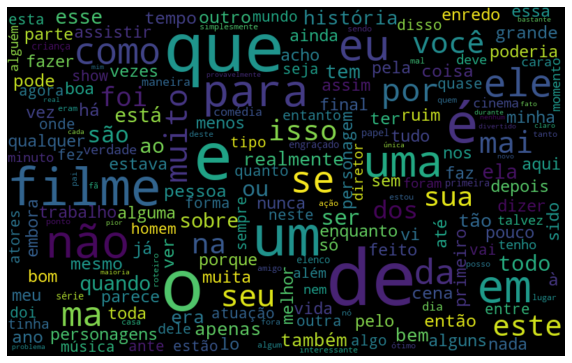

In [10]:
# Plotting word cloud

plot_word_cloud(imdb_reviews, "text_pt")

Indeed, there are several stop words, such as é, seu, que, para, etc, that blur our sentiment analysis by not carrying no relevant information. Let's remove and stem them from our text as well as diacritical signs and punctuation to store them in a new data frame column.

In [11]:
# Creating a list with PT_BR stop words

pt_stop_words = nltk.corpus.stopwords.words("portuguese")

# Removing punctuation

imdb_reviews["text_pt"] = imdb_reviews["text_pt"].str.replace(r"[^\w\s]+", "")

C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [12]:
# Removing the stop words and punctuation

imdb_reviews["text_pt_no_stopwords"] = imdb_reviews["text_pt"].apply(lambda x: ' '\
                                    .join([word for word in x.split() if word not in (pt_stop_words)]))

# Removing the diacritical signs and converting into lower case

imdb_reviews["text_pt_no_stopwords"] = imdb_reviews["text_pt_no_stopwords"].apply(lambda x: ' '\
                                    .join([unidecode(word.lower()) for word in x.split()]))

# Stemming the words

pt_stemmer = RSLPStemmer()
imdb_reviews["text_pt_no_stopwords"] = imdb_reviews["text_pt_no_stopwords"].apply(lambda x: ' '\
                                    .join([pt_stemmer.stem(word) for word in x.split()]))

In [13]:
# Check the cleaning texts

imdb_reviews.head()

,id,text_en,text_pt,sentiment,sentiment_bool,text_pt_no_stopwords
0,1,Once again Mr. Costner has dragged out a movie...,Mais uma vez o Sr Costner arrumou um filme por...,neg,0,mais vez sr costn arrum film temp necessari al...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,est exempl motiv maior film aca mesm gener cha...
2,3,"First of all I hate those moronic rappers, who...",Primeiro de tudo eu odeio esses raps imbecis q...,neg,0,prim tud odei rap imbecil pod agir arm pressio...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,nem beatl pud escrev music tod gost emb walt h...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,film fot lata palavr apropri verdad tant ous s...


Our data set is now ready to build the model.

--- 

# Models

## Logistic regression

Logistic regression uses the so-called sigmoid function: $\sigma$(x) = $\frac{1}{1+e^{-x}}$, in this case, we are working with multidimensional data, so x $\equiv$ $\theta^{T}X$, where $\theta$ is the weight factors (in other words, the weight of each feature that contributes to the model, the higher the $\theta$, more important is that feature associated with this factor) and X will be our independent variables. The sigmoid function returns a number between 0 and 1, also called $\hat{y}$. This can be interpreted as the probability of the customer buying the gadget given its pieces of information (features), or mathematically speaking, P(Y=1|X). In every iteration, the algorithm will set $\theta$ randomly, calculate the sigmoid function, compare the output $\hat{y}$ with y, and calculate the error. The sum of all errors is called the cost of the model, 
Cost = J($\theta$) = $\frac{1}{m}$$\sum_{i=1}^{m} y^{i}log(\hat{y}^{i}) + (1-y^{i})log(1-y^{i})$. The model will use gradient descent to find the next values for $\theta$ and the process start over again until it minimizes the cost of the model. 

In calculus, the gradient ($\mathbf{\nabla}$) is a multivariable derivate of a function, also called vector in a 3D function, and it gives the information about the slope and direction of the curve uphill. So we need to take the -$\mathbf{\nabla}$ to update our parameter. There are no more updates when it reaches the global minimum of the cost function, that is why we choose the log function for our cost function rather than the sigmoid function. The sigmoid function is not always easy to find the global minimum. 

## AUC

ROC and AUC will be used to evaluate the models' performance.

ROC stands for Receiver Operating Characteristic, which illustrates the diagnostic ability of a binary classifier system (0 or 1, True or False, Fraud or Non-fraud, etc.) as its discrimination threshold, false positive and true positive rates, is varied.
True positive rate (TPR) or sensitivity is given by TPR = $\frac{TP}{TP+FN}$ where TP is the true positives and FN is the false negatives. The false positive rate (FPR), or specificity, is defined by FPR = $\frac{FP}{FP+TN}$ where FP is the false positives and the TN is the true negatives. 

To build the ROC curve, the algorithm takes the predicted label outcomes and sets several thresholds to classify 0 or 1. Then it calculates the TPR and FPR for all of them. The red dotted line is the area where TPR = FPR, that is, a bad classifier. The further the curve is away from this straight line the better. The perfect classifier model passes through (0,1).

AUC is the area under the ROC curve and we can compare which curve (and model) is the best. The area varies between 0 and 1 and the closer to 1, the better. 

ROC and AUC summarize several confusion matrices information into one  metric, which is helpful when dealing with classification problems and threshold variation.

For this classification problem, let's build a model using non-cleaned data as the baseline. Soon we will compare this model with future ones using cleaned text.

In [14]:
# Setting the random state as 42 for all models

SEED = 42

In [15]:
# Creating train and test sets

vectorized_words = CountVectorizer(lowercase=False, max_features=50)
bag_of_words_no_cleaned = vectorized_words.fit_transform(imdb_reviews["text_pt"])
X_train, X_test, y_train, y_test = train_test_split(bag_of_words_no_cleaned,
                                                          imdb_reviews["sentiment_bool"],
                                                          random_state = SEED)

In [16]:
# Fitting and predicting

lr_clf = LogisticRegression(solver = "lbfgs", random_state=SEED)
lr_clf.fit(X_train, y_train)
y_pred =lr_clf.predict(X_test)

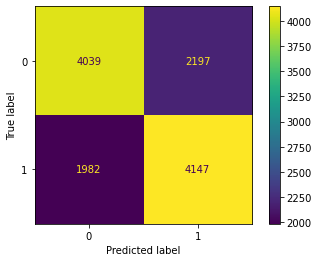

In [17]:
# Plotting the confusion matrix

%matplotlib inline

plot_confusion_matrix(y_test, y_pred)

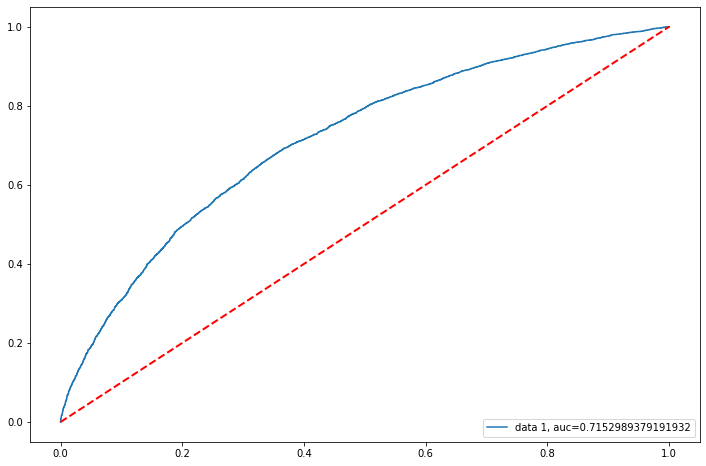

In [18]:
# Plotting ROC

y_pred_proba = lr_clf.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plot_roc_auc(fpr, tpr, auc)

The AUC for non-cleaned data is 0.715. Let's compare it with the cleaned data model.

In [19]:
# Creating train and test sets for cleaned data

vectorized_words_cleaned = CountVectorizer(lowercase=False, max_features=50)
bag_of_words_cleaned = vectorized_words_cleaned.fit_transform(imdb_reviews["text_pt_no_stopwords"])
X_train, X_test, y_train, y_test = train_test_split(bag_of_words_cleaned,
                                                          imdb_reviews["sentiment_bool"],
                                                          random_state = SEED)

In [20]:
# Fitting and predicting

lr_clf.fit(X_train, y_train)
y_pred =lr_clf.predict(X_test)

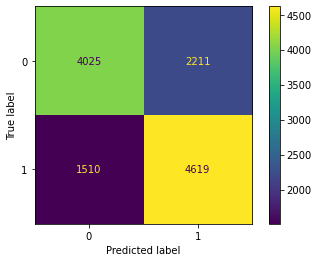

In [21]:
# Plotting the confusion matrix

%matplotlib inline

plot_confusion_matrix(y_test, y_pred)

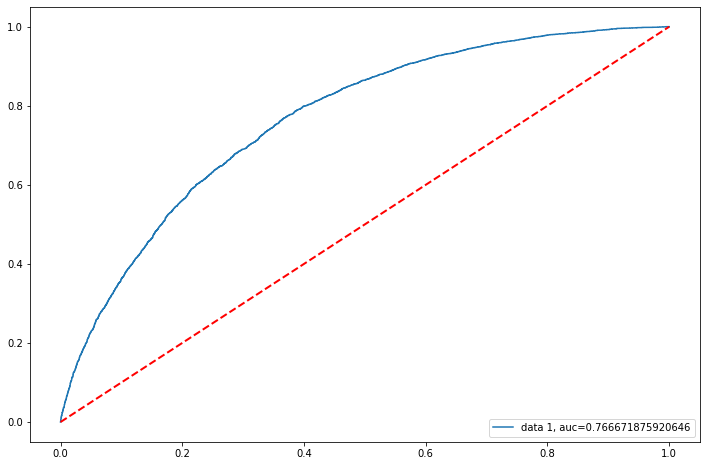

In [22]:
# Plotting ROC

y_pred_proba = lr_clf.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plot_roc_auc(fpr, tpr, auc)

Now, the AUC score increased to 0.767, and looking at the confusion matrix, the number of false negatives decreased, contributing to the new AUC.

--- 

# TF-IDF

TF-IDF, which stands for Term frequency-inverse, document frequency, is another way to count words in the bag of words. It measures how important a term (word) is in the document by calculating how many times it appears in a given document (text or data frame rows) and is rare in others. Mathematically speaking, TF-IDF is defined by: 

TF-IDF = TF*IDF, where

TF = $\frac{\text{number of times the term appears in the document}}{\text{total number of words in the document}}$,

and 

IDF = $\log(\frac{\text{total number of documents}}{\text{number of documents the term appears on}})$.

In other words, if a word appears in several documents in the corpus, it likely carries no new or little information to, for example, identify sentiment. But, if a term is cited often in one specific document and it appears less in the others, it is probably not a stop word and is relevant for the analysis. 

Let's implement TF-IDF in our data set and see if it can improve our model score.

In [23]:
# Creating tf-idf model

reviews_tfidf = TfidfVectorizer()
review_words = reviews_tfidf.fit_transform(imdb_reviews["text_pt_no_stopwords"])
X_train, X_test, y_train, y_test = train_test_split(review_words,
                                                          imdb_reviews["sentiment_bool"],
                                                          random_state = SEED)

In [24]:
# Fitting and predicting the model

lr_clf.fit(X_train, y_train)
y_pred_tfidf =lr_clf.predict(X_test)

C:\Users\steph\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


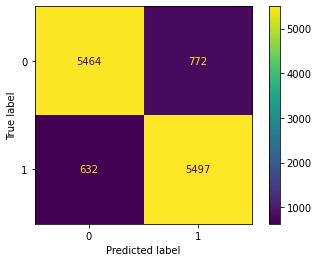

In [25]:
# Plotting the confusion matrix for tf-idf

%matplotlib inline

plot_confusion_matrix(y_test, y_pred_tfidf)

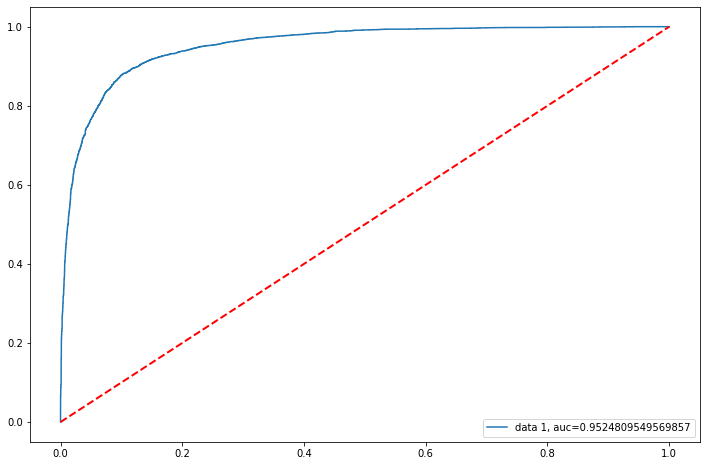

In [26]:
# Plotting ROC for tf-idf

y_pred_proba_tfidf = lr_clf.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba_tfidf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_tfidf)

plot_roc_auc(fpr, tpr, auc)

Using TF-IDF the model had an AUC score of 0.955 which is a huge improvement compared to the last model. Since we are dealing with sentiment analysis, maybe this result is due to overfitting, i.e., the model is very well-trained with the training set and had poor performance with unseen data. 

---

# Word clouds

Let's build word clouds for positive and negative reviews to see the most important terms in both cases.

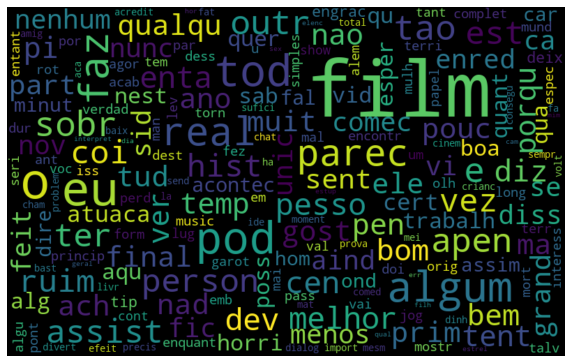

In [27]:
# Plotting word cloud for negative reviews

plot_word_cloud(imdb_reviews, "text_pt_no_stopwords", "sentiment", "neg")

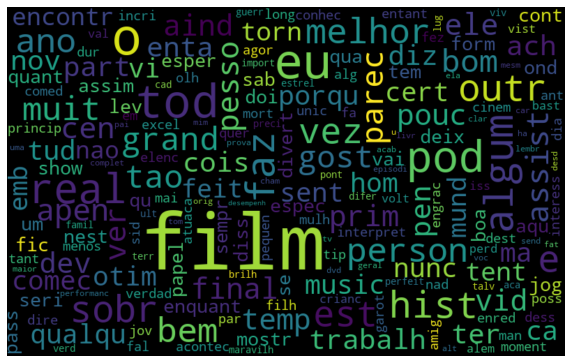

In [28]:
# Plotting word cloud for positive reviews

plot_word_cloud(imdb_reviews, "text_pt_no_stopwords", "sentiment", "pos")

Both word clouds show the key terms more clearly than before the cleaning process. It is possible to see words like "bom", "melhor", "bem", "excelente" for positive reviews and "ruim", "terrível", "horrível" for negative ones. 

---